In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter

In [24]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [25]:
train_df = pd.read_csv(Config.TRAIN_PATH)
train_labels = pd.read_csv(Config.TRAIN_LABELS)

In [26]:
train_labels['question'] = train_labels['session_id'].str.split('q').str[-1].astype('int8')
train_labels['session'] = train_labels['session_id'].str.split('_').str[0]
train_labels.head()

,session_id,correct,question,session
0,20090312431273200_q1,1,1,20090312431273200
1,20090312433251036_q1,0,1,20090312433251036
2,20090314121766812_q1,1,1,20090314121766812
3,20090314363702160_q1,1,1,20090314363702160
4,20090314441803444_q1,1,1,20090314441803444


In [27]:
train_labels['session'] = train_labels['session'].astype('int64')

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
ROOMS = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse',
          'capitol_2']

In [36]:
def groupby_apply_elapsed_time(g):
    res = {}
    diff = np.diff(g['elapsed_time'].values)
    res['elapsed_time_diff_mean'] = np.mean(diff)
    res['elapsed_time_diff_std'] = np.std(diff)
    res['elapsed_time_positive'] = len(diff[diff>0])
    res['elapsed_time_negative'] = len(diff) - res['elapsed_time_positive']
    res['start-end'] = g['elapsed_time'].values[-1] - g['elapsed_time'].values[0]
    return pd.Series(res)

In [37]:
def feature_engineer(train):
    dfs = []
    tmp = train.groupby(['session_id','level_group']).apply(groupby_apply_elapsed_time)
    dfs.append(tmp)
    for c in EVENTS:
        train[c] = (train.event_name == c)
    train['main_room'] = train['room_fqid'].str.split('.').str[1]
    for c in ROOMS:
        train[c] = (train.main_room == c)
    for c in EVENTS +ROOMS+ ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS + EVENTS + ROOMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS+ EVENTS + ROOMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    train = train.drop(EVENTS+ROOMS,axis=1)

    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [38]:
%%time
df = feature_engineer(train_df)
print( df.shape )
df.head()

(35337, 82)
CPU times: total: 3min 6s
Wall time: 6min 39s


,level_group,elapsed_time_diff_mean,elapsed_time_diff_std,elapsed_time_positive,elapsed_time_negative,start-end,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,...,historicalsociety_std,kohlcenter_std,capitol_0_std,humanecology_std,drycleaner_std,library_std,capitol_1_std,wildlife_std,flaghouse_std,capitol_2_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,1188.170732,2447.579017,161.0,3.0,194860.0,81,22,28,11,...,0.410055,0.401218,0.109760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20090312431273200,13-22,1040.446301,1985.279111,411.0,8.0,435947.0,170,123,60,20,...,0.497842,0.000000,0.000000,0.000000,0.000000,0.293894,0.152637,0.432144,0.265619,0.068924
20090312431273200,5-12,941.525424,714.119241,291.0,4.0,277750.0,103,104,12,28,...,0.500744,0.000000,0.171991,0.356344,0.315267,0.362904,0.205262,0.000000,0.000000,0.000000
20090312433251036,0-4,1693.855072,3504.819590,136.0,2.0,233752.0,49,18,36,15,...,0.431407,0.422493,0.119517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20090312433251036,13-22,2036.150463,10339.121375,1267.0,29.0,2638851.0,637,145,65,83,...,0.491914,0.271684,0.000000,0.236403,0.208456,0.305490,0.067884,0.326310,0.194434,0.343418


In [39]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [40]:
FEATURES = [c for c in df.columns if c != 'level_group' ]
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 81 features
We will train with 11779 users info


In [58]:
n_splits=5
gkf = GroupKFold(n_splits=n_splits)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 4,
        'n_estimators': 1500,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight':0.01,
        'use_label_encoder' : False}

    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_labels.loc[train_labels.question==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_labels.loc[train_labels.question==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(train_x[FEATURES].astype('float32'), train_y['correct']), (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=100)
        print(f'{t}({clf.best_ntree_limit}), ',end='')

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]

    print()



#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.69739	validation_1-logloss:0.69761


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.94257	validation_1-logloss:0.95144
1(1), [0]	validation_0-logloss:0.69278	validation_1-logloss:0.69271


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.70382	validation_1-logloss:0.70055
2(1), [0]	validation_0-logloss:0.69778	validation_1-logloss:0.69777


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.91871	validation_1-logloss:0.91557
3(1), [0]	validation_0-logloss:0.69869	validation_1-logloss:0.69878


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.97734	validation_1-logloss:0.98099
4(1), [0]	validation_0-logloss:0.69411	validation_1-logloss:0.69407


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[50]	validation_0-logloss:0.81450	validation_1-logloss:0.81305
5(1), [0]	validation_0-logloss:0.69832	validation_1-logloss:0.69800


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.97051	validation_1-logloss:0.95697
6(1), [0]	validation_0-logloss:0.69758	validation_1-logloss:0.69732


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.94840	validation_1-logloss:0.93838
7(1), [0]	validation_0-logloss:0.69535	validation_1-logloss:0.69563


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.86163	validation_1-logloss:0.87302
8(1), [0]	validation_0-logloss:0.69768	validation_1-logloss:0.69745


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[50]	validation_0-logloss:0.95930	validation_1-logloss:0.94933
9(1), [0]	validation_0-logloss:0.69318	validation_1-logloss:0.69331


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[50]	validation_0-logloss:0.77588	validation_1-logloss:0.78164
10(1), [0]	validation_0-logloss:0.69599	validation_1-logloss:0.69592


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[50]	validation_0-logloss:0.89163	validation_1-logloss:0.88873
11(1), [0]	validation_0-logloss:0.69933	validation_1-logloss:0.69934


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:1.00894	validation_1-logloss:1.00839
12(1), [0]	validation_0-logloss:0.68865	validation_1-logloss:0.68863


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[100]	validation_0-logloss:0.60632	validation_1-logloss:0.60533
[111]	validation_0-logloss:0.61884	validation_1-logloss:0.61776
13(62), [0]	validation_0-logloss:0.69722	validation_1-logloss:0.69704


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.93604	validation_1-logloss:0.92853
14(1), [0]	validation_0-logloss:0.69291	validation_1-logloss:0.69265


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[54]	validation_0-logloss:0.77534	validation_1-logloss:0.76364
15(6), [0]	validation_0-logloss:0.69766	validation_1-logloss:0.69771


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[49]	validation_0-logloss:0.95348	validation_1-logloss:0.95541
16(1), [0]	validation_0-logloss:0.69669	validation_1-logloss:0.69693


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[50]	validation_0-logloss:0.92017	validation_1-logloss:0.93022
17(1), 

C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


KeyboardInterrupt: 

In [44]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [46]:
feat_imp = {}

In [47]:
for k, v in models.items():
    for x, y in zip(v.feature_importances_, v.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x

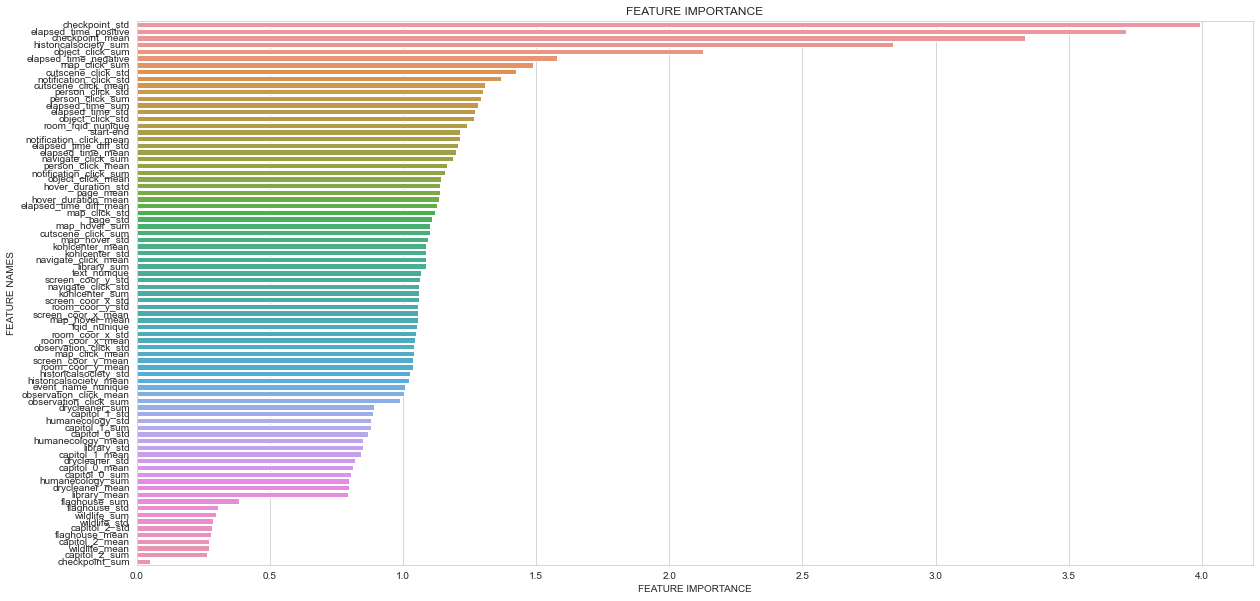

In [50]:
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [51]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = train_labels.loc[train_labels.question == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [52]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

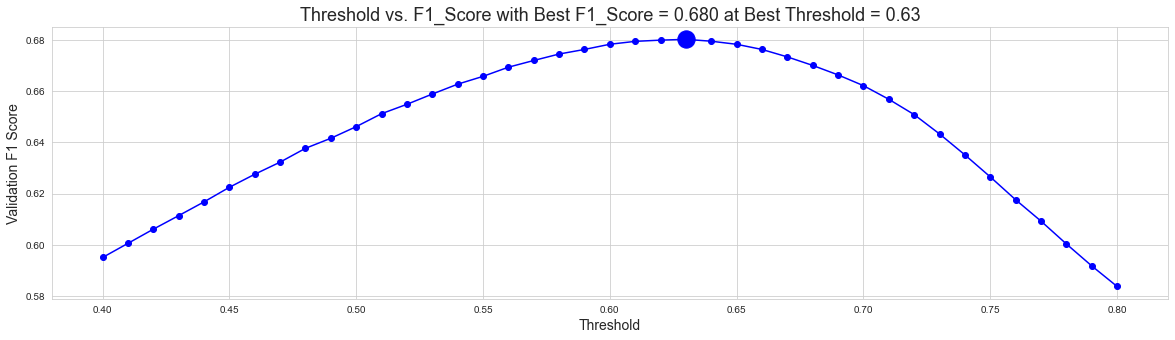

In [53]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [56]:
train_labels.groupby('question')['correct'].value_counts()

question  correct
1         1           8528
          0           3251
2         1          11529
          0            250
3         1          10980
          0            799
4         1           9415
          0           2364
5         1           6436
          0           5343
6         1           9094
          0           2685
7         1           8590
          0           3189
8         1           7236
          0           4543
9         1           8663
          0           3116
10        1           5894
          0           5885
11        1           7588
          0           4191
12        1          10100
          0           1679
13        0           8593
          1           3186
14        1           8364
          0           3415
15        0           6090
          1           5689
16        1           8691
          0           3088
17        1           8072
          0           3707
18        1          11197
          0            582
Name: corr